---
Analyse air quality data file from CICERO and prepare DHIS2 friendly json file 
---

---
In this notebook, you will find notes on
---
1. Retrieving bias corrected airquality data from the NetCDF file shared by CICERO
2. Aggregating the data to DHIS2 organisation units
3. Merging and reconstructing population data files from GHS repository
4. Calculating population weighted PM2.5 averages for districts
5. Preparing final DHIS2 friendly json file for uploading

In [1]:
import earthkit.data
from earthkit.transforms import aggregate
from dhis2eo.integrations.pandas import dataframe_to_dhis2_json

In [2]:
import dhis2eo, sys
print("Python:", sys.version)
print("dhis2eo:", getattr(dhis2eo, "__version__", "installed"))

Python: 3.11.0 (main, Oct 24 2022, 18:26:48) [MSC v.1933 64 bit (AMD64)]
dhis2eo: installed


In [3]:
import xarray as xr

# Define the source AQ file path in .nc format
NC_FILE = r"C:\Users\HP\Downloads\pm_final_srilanka_linearp.nc"

ds = xr.open_dataset(NC_FILE, chunks={"time": 30})  # lazy load, memory-friendly
display(ds)               # full dataset summary
print("Variables:", list(ds.data_vars))  # see available variable names
print("Coords:", list(ds.coords))

<xarray.Dataset> Size: 2GB
Dimensions:                        (time: 1401, lat: 450, lon: 450)
Coordinates:
  * time                           (time) datetime64[ns] 11kB 2020-03-01 ... ...
  * lat                            (lat) float32 2kB 5.505 5.515 ... 9.985 9.995
  * lon                            (lon) float32 2kB 78.0 78.01 ... 82.49 82.5
Data variables:
    __xarray_dataarray_variable__  (time, lat, lon) float64 2GB dask.array<chunksize=(30, 450, 450), meta=np.ndarray>

Variables: ['__xarray_dataarray_variable__']
Coords: ['time', 'lat', 'lon']


In [4]:
# Rename the anonymous variable to something clearer
ds = ds.rename({"__xarray_dataarray_variable__": "pm25"})

# Quick look at values and metadata
print(ds.pm25)
print("Min:", float(ds.pm25.min().compute()))
print("Max:", float(ds.pm25.max().compute()))

<xarray.DataArray 'pm25' (time: 1401, lat: 450, lon: 450)> Size: 2GB
dask.array<open_dataset-__xarray_dataarray_variable__, shape=(1401, 450, 450), dtype=float64, chunksize=(30, 450, 450), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 11kB 2020-03-01 2020-03-02 ... 2023-12-31
  * lat      (lat) float32 2kB 5.505 5.515 5.525 5.535 ... 9.975 9.985 9.995
  * lon      (lon) float32 2kB 78.0 78.01 78.03 78.04 ... 82.46 82.47 82.49 82.5
Min: 0.031555434215710894
Max: 1443.654129238274


1. Import required libraries.
2. Define Sri Lanka’s geographic bounds.
3. Ensure the dataset has a CRS (EPSG:4326).
4. Demarcate PM₂.₅ data to Sri Lanka’s bounding box. (These dimensions to be used for cropping the population data file later) 
5. Select one day (first available) and plots PM₂.₅ values on a map.

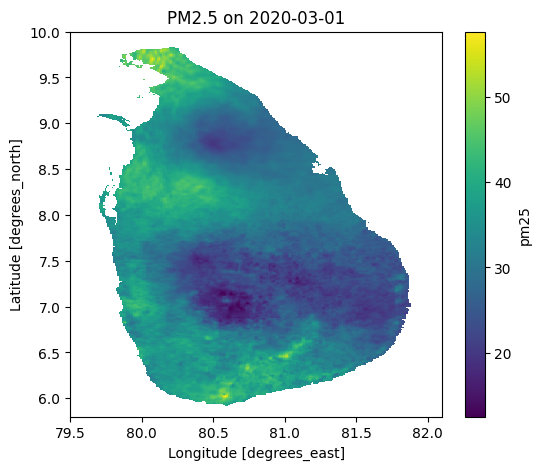

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import rioxarray  # ensures .rio accessor exists

# Sri Lanka bbox
lat_min, lat_max = 5.8, 10.2
lon_min, lon_max = 79.5, 82.1

pm = ds.pm25
if not pm.rio.crs:
    pm = pm.rio.write_crs(4326)

# Subset to bbox (handles ascending/descending lat)
lat_slice = slice(lat_min, lat_max) if pm.lat[0] < pm.lat[-1] else slice(lat_max, lat_min)
pm_sl = pm.sel(lat=lat_slice, lon=slice(lon_min, lon_max))

# Pick and plot first day (fallback to nearest if exact match fails)
try:
    day = pd.to_datetime(pm_sl.time.values[0]).date()
    to_plot = pm_sl.sel(time=str(day))
except Exception:
    to_plot = pm_sl.isel(time=0)
    day = pd.to_datetime(pm_sl.time.values[0]).date()

# --- FIXED plotting ---
fig, ax = plt.subplots(figsize=(6,5))
to_plot.plot(ax=ax)
ax.set_title(f"PM2.5 on {day}")
plt.show()

Retrieve district polygon coordinates from the DHIS2 instance itself
-

In [6]:
import os, requests, geopandas as gpd
from shapely.geometry import shape

# ---- Credentials for accessing the particular DHIS2 instance ----
BASE = "https://climate.health.gov.lk"  # no trailing slash
USER = "ruvinda"
PASS = "Test123#$"

# fetch org units at district level (At OU level 3)
OU_LEVEL = 3

r = requests.get(
    f"{BASE.rstrip('/')}/api/organisationUnits.json",
    params={"fields": "id,name,geometry", "paging": "false", "level": OU_LEVEL},
    auth=(USER, PASS),
    timeout=120
)
r.raise_for_status()
units = r.json().get("organisationUnits", [])
polys = [u for u in units if u.get("geometry") and u["geometry"].get("type") in ("Polygon","MultiPolygon")]

gdf_districts = gpd.GeoDataFrame(
    [{"id": u["id"], "name": u["name"], "geometry": shape(u["geometry"])} for u in polys],
    crs="EPSG:4326"
)
print(f"Loaded {len(gdf_districts)} districts with geometry at level {OU_LEVEL}.")
gdf_districts.head()

Loaded 26 districts with geometry at level 3.


,id,name,geometry
0,Z2RsgSDpXVp,Ampara RDHS,"MULTIPOLYGON (((81.6958 7.2654, 81.6993 7.2604..."
1,Jns2a9OHqWL,Anuradhapura RDHS,"POLYGON ((80.9411 8.3424, 80.9321 8.3462, 80.9..."
2,tmYbVNQz6uy,Badulla RDHS,"POLYGON ((81.2708 7.278, 81.2684 7.2774, 81.26..."
3,a7Gms6C9rXA,Batticaloa RDHS,"POLYGON ((81.4036 8.2655, 81.4066 8.2549, 81.4..."
4,jHziKXGUJG0,Colombo RDHS,"POLYGON ((80.1784 6.9786, 80.1827 6.9759, 80.1..."


Importing necessary libraries and defining the input and output objects

The goal of this script is to:

*Combine (mosaic) four population raster tiles into one large raster file that covers all of Sri Lanka.
*Clip that combined raster to exactly match the area of Sri Lanka refering to the bounding box used in the air quality (AQ) analysis.

In [7]:
# --- Mosaic 4 GHS tiles and reproject to EPSG:4326 (WGS84) ---
import os
from pathlib import Path
import rasterio
from rasterio.merge import merge
import rioxarray as rxr

# Inputs
files = [
    r"C:\climate-tools-notebooks\climate-tools\docs\data\GHS_POP_E2020_GLOBE_R2023A_54009_1000_V1_0_R9_C26.tif",
    r"C:\climate-tools-notebooks\climate-tools\docs\data\GHS_POP_E2020_GLOBE_R2023A_54009_1000_V1_0_R8_C26.tif",
    r"C:\climate-tools-notebooks\climate-tools\docs\data\GHS_POP_E2020_GLOBE_R2023A_54009_1000_V1_0_R9_C27.tif",
    r"C:\climate-tools-notebooks\climate-tools\docs\data\GHS_POP_E2020_GLOBE_R2023A_54009_1000_V1_0_R8_C27.tif"
]

out_dir = r"C:\climate-tools-notebooks\climate-tools\docs\data"
os.makedirs(out_dir, exist_ok=True)
mosaic_path = str(Path(out_dir) / "GHS_POP_SriLanka_mosaic_54009.tif")
wgs84_path  = str(Path(out_dir) / "GHS_POP_SriLanka_mosaic_WGS84.tif")

# 1) Mosaic in native CRS (likely EPSG:54009 for World Mollweide)
srcs = [rasterio.open(fp) for fp in files]
mosaic, out_transform = merge(srcs)
profile = srcs[0].profile.copy()
for s in srcs: s.close()

profile.update(
    height=mosaic.shape[1],
    width=mosaic.shape[2],
    transform=out_transform,
    compress="lzw",
    tiled=True,
    bigtiff="IF_SAFER"
)

with rasterio.open(mosaic_path, "w", **profile) as dst:
    dst.write(mosaic)

print("Wrote mosaic:", mosaic_path)

# 2) Reproject to EPSG:4326 (WGS84)
pop_mosaic = rxr.open_rasterio(mosaic_path).squeeze(drop=True)
pop_wgs84  = pop_mosaic.rio.reproject("EPSG:4326")
pop_wgs84.rio.to_raster(wgs84_path, compress="lzw")
print("Reprojected to WGS84:", wgs84_path)

# 3) Point POP_PATH to this new file so downstream code picks it up
from pathlib import Path
POP_PATH = Path(wgs84_path)
print("POP_PATH set to:", POP_PATH)


Wrote mosaic: C:\climate-tools-notebooks\climate-tools\docs\data\GHS_POP_SriLanka_mosaic_54009.tif
Reprojected to WGS84: C:\climate-tools-notebooks\climate-tools\docs\data\GHS_POP_SriLanka_mosaic_WGS84.tif
POP_PATH set to: C:\climate-tools-notebooks\climate-tools\docs\data\GHS_POP_SriLanka_mosaic_WGS84.tif


In [21]:
import rioxarray as rxr
pop = rxr.open_rasterio(POP_PATH, masked=True).squeeze("band", drop=True)

In [26]:
# --- SMOKE TEST: 1 day × 3 districts with verbose prints ---

import numpy as np, pandas as pd, xarray as xr, rioxarray, rasterio as rio, sys

# Basic sanity prints
print("PM dims:", ds.pm25.dims, "| times:", ds.pm25.sizes.get("time"))
print("POP dims:", pop.dims, "| CRS:", pop.rio.crs)
print("Districts:", len(gdf_districts))
sys.stdout.flush()

# Prep PM (1 day)
da = ds.pm25
if not da.rio.crs: da = da.rio.write_crs(4326)
da = da.rename({ [d for d in da.dims if d.lower().startswith("lat") or d.lower() in ("y","latitude")][0]:"lat",
                 [d for d in da.dims if d.lower().startswith("lon") or d.lower() in ("x","longitude")][0]:"lon"})
da = da.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=False)
t = pd.to_datetime(da.time.values[0])
day_pm = da.sel(time=t)

# Prep POP
pop_da = pop
if not pop_da.rio.crs: pop_da = pop_da.rio.write_crs(4326)
rename_map = {}
if "y" in pop_da.dims: rename_map["y"]="lat"
if "x" in pop_da.dims: rename_map["x"]="lon"
if "latitude" in pop_da.dims: rename_map["latitude"]="lat"
if "longitude" in pop_da.dims: rename_map["longitude"]="lon"
if rename_map: pop_da = pop_da.rename(rename_map)
pop_da = pop_da.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=False)

# Regrid POP to PM grid
print("Reprojecting population to PM grid...")
pop_on_pm = pop_da.rio.reproject_match(day_pm, resampling=rio.enums.Resampling.sum)
print("Done. pop_on_pm shape:", pop_on_pm.shape)
sys.stdout.flush()

# Take 3 districts
gdf = gdf_districts.to_crs(4326).head(3)

rows=[]
for _, r in gdf.iterrows():
    pm_clip  = day_pm.rio.clip([r.geometry], gdf.crs, drop=True)
    pop_clip = pop_on_pm.rio.clip([r.geometry], gdf.crs, drop=True)
    pm_clip, pop_clip = xr.align(pm_clip, pop_clip, join="inner")
    valid = np.isfinite(pm_clip) & np.isfinite(pop_clip) & (pop_clip > 0)
    if not valid.any().compute():
        print("No valid cells for:", r["name"])
        continue
    num = (pm_clip.where(valid) * pop_clip.where(valid)).sum().compute().item()
    den = (pop_clip.where(valid)).sum().compute().item()
    val = num/den
    rows.append({"period": t.strftime("%Y%m%d"), "orgUnit": r["id"], "name": r["name"], "value": round(float(val),2)})

print("SMOKE TEST RESULTS:")
print(pd.DataFrame(rows))

PM dims: ('time', 'lat', 'lon') | times: 1401
POP dims: ('y', 'x') | CRS: EPSG:4326
Districts: 26
Reprojecting population to PM grid...
Done. pop_on_pm shape: (450, 450)
SMOKE TEST RESULTS:
     period      orgUnit               name  value
0  20200301  Z2RsgSDpXVp        Ampara RDHS  23.95
1  20200301  Jns2a9OHqWL  Anuradhapura RDHS  34.76
2  20200301  tmYbVNQz6uy       Badulla RDHS  23.86


In [31]:
# --- POP-WEIGHTED PM2.5 BY DISTRICT (FAST, VECTORIZED, WITH PROGRESS) ---
import json, pathlib, time, warnings
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import rioxarray
import rasterio as rio
from rasterio import features

# Optional: Dask progress bar (shows live progress during compute)
try:
    from dask.diagnostics import ProgressBar
    HAVE_PBAR = True
except Exception:
    HAVE_PBAR = False

# ------------------ CONFIG ------------------
DATA_ELEMENT_ID = "tFvNHy7dkQr"
CATEGORY_OPTION_COMBO_ID = "HllvX50cXC0"
OUT_JSON = pathlib.Path("pm25_popweighted_district_daily.json")
PM_VAR = "pm25"
ROUND_DECIMALS = 2

# Rasterization behavior: True includes any touched pixel (slightly larger coverage)
RASTERIZE_ALL_TOUCHED = False

# Chunk sizes (tune for your machine)
TIME_CHUNK = 30        # number of days per chunk
SPATIAL_CHUNK = 512    # pixels per side (512/768/1024, depending on RAM)
PERSIST_HOT_ARRAYS = True  # keep heavy arrays in memory to speed later steps
# --------------------------------------------

t0 = time.perf_counter()
warnings.filterwarnings("ignore", category=FutureWarning)

# --- 0) Inputs expected in your session: ds (Dataset or DataArray), pop (DataArray), gdf_districts (GeoDataFrame) ---
assert isinstance(gdf_districts, gpd.GeoDataFrame), "gdf_districts not found"

gdf = gdf_districts.copy()
if gdf.crs is None or gdf.crs.to_epsg() != 4326:
    print("[prep] Reprojecting districts → EPSG:4326 ...")
    gdf = gdf.to_crs(4326)

# PM ensure dims & CRS
da = ds[PM_VAR] if isinstance(ds, xr.Dataset) else ds
lat_name = [d for d in da.dims if d.lower().startswith("lat") or d.lower() in ("y","latitude")][0]
lon_name = [d for d in da.dims if d.lower().startswith("lon") or d.lower() in ("x","longitude")][0]
if (lat_name, lon_name) != ("lat", "lon"):
    print(f"[prep] Renaming PM dims {lat_name},{lon_name} → lat,lon")
    da = da.rename({lat_name: "lat", lon_name: "lon"})
if not da.rio.crs:
    da = da.rio.write_crs(4326)
da = da.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=False)

# POP → normalize dims, set CRS, match PM grid
pop_da = pop
rename_map = {}
for cand, target in (("y","lat"),("x","lon"),("latitude","lat"),("longitude","lon")):
    if cand in pop_da.dims: rename_map[cand] = target
if rename_map:
    print(f"[prep] Renaming POP dims {rename_map} ...")
    pop_da = pop_da.rename(rename_map)
if not pop_da.rio.crs:
    pop_da = pop_da.rio.write_crs(4326)
pop_da = pop_da.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=False)

template = da.isel(time=0)
print("[prep] Reprojecting population to PM grid (sum resampling) ...")
pop_on_pm = pop_da.rio.reproject_match(template, resampling=rio.enums.Resampling.sum)

# Harmonize dims/coords after reproject (x,y → lon,lat; exact coords from template)
if {"x","y"}.issubset(set(pop_on_pm.dims)):
    pop_on_pm = pop_on_pm.rename({"x":"lon", "y":"lat"})
pop_on_pm = pop_on_pm.assign_coords(lon=template["lon"].values, lat=template["lat"].values)
pop_on_pm = pop_on_pm.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=False)

print(f"[grid] PM grid: time={da.sizes.get('time', 1)}, lat={da.sizes['lat']}, lon={da.sizes['lon']}")
print(f"[grid] POP on PM: lat={pop_on_pm.sizes['lat']}, lon={pop_on_pm.sizes['lon']}")

# --- 1) Chunk for Dask ---
chunks_da = {"time": TIME_CHUNK, "lat": SPATIAL_CHUNK, "lon": SPATIAL_CHUNK}
chunks_pop = {"lat": SPATIAL_CHUNK, "lon": SPATIAL_CHUNK}
print(f"[chunk] PM chunks: {chunks_da}")
print(f"[chunk] POP chunks: {chunks_pop}")
da = da.chunk(chunks_da)
pop_on_pm = pop_on_pm.chunk(chunks_pop)

# --- 2) Rasterize districts ONCE to a label grid ---
print("[labels] Rasterizing districts → label grid ...")
shapes = []
missing = 0
for i, geom in enumerate(gdf.geometry):
    if geom is None or geom.is_empty:
        missing += 1
        continue
    shapes.append((geom, i))
if missing:
    print(f"[labels] Skipped {missing} empty geometries")

transform = template.rio.transform()
out_shape = (template.sizes["lat"], template.sizes["lon"])
labels_np = features.rasterize(
    shapes=shapes,
    out_shape=out_shape,
    transform=transform,
    fill=-1,                  # -1 = outside any district
    dtype="int32",
    all_touched=RASTERIZE_ALL_TOUCHED
)
labels = xr.DataArray(
    labels_np,
    coords={"lat": template["lat"], "lon": template["lon"]},
    dims=("lat","lon"),
    name="district_label"
)
print(f"[labels] Rasterized {len(gdf)} district labels")

# --- IMPORTANT FIX: compute labels to memory (groupby requires non-chunked labels) ---
labels = labels.astype("int32").compute()
valid  = labels >= 0

# Optionally persist heavy arrays for speed
if PERSIST_HOT_ARRAYS:
    try:
        print("[persist] Persisting pop_on_pm (kept in memory for faster ops) ...")
        pop_on_pm = pop_on_pm.persist()
    except Exception:
        print("[persist] Could not persist; continuing without.")

# --- 3) Vectorized population-weighted means for ALL days × districts ---
print("[agg] Building Dask graph for population-weighted means (num/den) ...")
num = (da * pop_on_pm).where(valid).groupby(labels).sum()
den = (pop_on_pm).where(valid).groupby(labels).sum()
pw  = num / den  # dims: time x labels

# --- 4) Compute with progress & convert to DataFrame ---
def _compute_to_df(pw_da: xr.DataArray) -> pd.DataFrame:
    if HAVE_PBAR:
        print("[compute] Executing (with Dask ProgressBar) ...")
        with ProgressBar():
            df = pw_da.to_dataframe(name="value").reset_index()
    else:
        print("[compute] Executing ...")
        df = pw_da.to_dataframe(name="value").reset_index()
    return df

t1 = time.perf_counter()
df_pw = _compute_to_df(pw)
t2 = time.perf_counter()
print(f"[compute] Done in {t2 - t1:0.2f}s")

# --- 5) Post-process & summarize ---
df_pw["orgUnit"] = df_pw["district_label"].map(dict(enumerate(gdf["id"].tolist())))
df_pw["name"]    = df_pw["district_label"].map(
    dict(enumerate(gdf.get("name", pd.Series([""]*len(gdf))).tolist()))
)

if "time" in df_pw.columns:
    df_pw["period"] = pd.to_datetime(df_pw["time"]).dt.strftime("%Y%m%d")
    df_pw = df_pw.drop(columns=["time"])
else:
    # If no time dimension, use template's time (rare)
    df_pw["period"] = pd.Timestamp(template["time"].item()).strftime("%Y%m%d")

df_pw = df_pw.drop(columns=["district_label"])
df_pw = df_pw.replace([np.inf, -np.inf], np.nan).dropna(subset=["value"])
df_pw["value"] = df_pw["value"].round(ROUND_DECIMALS)

n_days = df_pw["period"].nunique()
n_ou   = df_pw["orgUnit"].nunique()
print(f"[summary] Rows: {len(df_pw)} | Days: {n_days} | Districts: {n_ou}")
print(df_pw.head(10).to_string(index=False))

# --- 6) Build DHIS2 payload & write ---
payload = {
    "dataValues": [
        {
            "dataElement": DATA_ELEMENT_ID,
            "period": rec.period,
            "orgUnit": rec.orgUnit,
            "categoryOptionCombo": CATEGORY_OPTION_COMBO_ID,
            "value": rec.value
        }
        for rec in df_pw.itertuples(index=False)
    ]
}
OUT_JSON.write_text(json.dumps(payload, ensure_ascii=False))
print(f"[write] Wrote JSON → {OUT_JSON.resolve()}")

t3 = time.perf_counter()
print(f"[total] Finished in {t3 - t0:0.2f}s")


[prep] Renaming POP dims {'y': 'lat', 'x': 'lon'} ...
[prep] Reprojecting population to PM grid (sum resampling) ...
[grid] PM grid: time=1401, lat=450, lon=450
[grid] POP on PM: lat=450, lon=450
[chunk] PM chunks: {'time': 30, 'lat': 512, 'lon': 512}
[chunk] POP chunks: {'lat': 512, 'lon': 512}
[labels] Rasterizing districts → label grid ...
[labels] Rasterized 26 district labels
[persist] Persisting pop_on_pm (kept in memory for faster ops) ...
[agg] Building Dask graph for population-weighted means (num/den) ...
[compute] Executing (with Dask ProgressBar) ...
[########################################] | 100% Completed | 16.83 s
[compute] Done in 17.52s
[summary] Rows: 36426 | Days: 1401 | Districts: 26
 spatial_ref  value     orgUnit              name   period
           0  23.93 Z2RsgSDpXVp       Ampara RDHS 20200301
           0  37.15 Jns2a9OHqWL Anuradhapura RDHS 20200301
           0  24.27 tmYbVNQz6uy      Badulla RDHS 20200301
           0  26.21 a7Gms6C9rXA   Batticaloa RDHS